# Understanding Prior Networks and Regression Prior Networks
   ### A Practical and Mathematical Guide to Uncertainty Modeling in Deep Learning

##  1. Introduction

Deep learning models are powerful, but standard neural networks cannot express uncertainty about their predictions. In many applications—such as self-driving cars, medical diagnosis, or other safety-critical systems—it is important to know *how confident* a model is in its output.

Traditionally, **neural network ensembles** are used to estimate uncertainty because they capture both:
- **Data uncertainty (aleatoric uncertainty)** → noise inherent in the data
- **Knowledge uncertainty (epistemic uncertainty)** → model ignorance, OOD inputs

However, ensembles are **computationally expensive**, because they require running **many neural networks** at inference time. This makes them impractical for real-world systems that need fast predictions.

To solve this, **Prior Networks** were introduced for **classification tasks**. Instead of predicting class probabilities directly (e.g., through a softmax layer), Prior Networks predict the parameters of a **Dirichlet distribution**, allowing a single model to mimic the uncertainty behavior of an entire ensemble.

This idea was later extended to continuous outputs in **Regression Prior Networks (Malinin et al., 2020)**, which use a **Normal–Wishart prior** and produce **Student-t predictive distributions**. These models allow single-network uncertainty estimation for regression problems.

In this notebook, we will:

- Understand why ensembles provide strong uncertainty
- Explain why ensembles are expensive at inference
- Show how Prior Networks solve the ensemble cost problem
- Explain how **classification Prior Networks** work (Dirichlet priors)
- Explain how **Regression Prior Networks** work (Normal–Wishart priors → Student-t output)
- Show how this relates to **Evidential Deep Learning (Sensoy et al., 2018)**


## 2. Ensembles and Why They Matter

Deep learning ensembles combine several independently trained models:


$ f^{(1)}, f^{(2)}, \dots, f^{(M)}$


Ensembles capture two types of uncertainty:

### 🔹 Data Uncertainty (Aleatoric)
Noise in the data.

### 🔹 Knowledge Uncertainty (Epistemic)
Model uncertainty due to lack of knowledge.

Ensembles are powerful but computationally expensive:

- $M×$ compute
- $M×$ memory
- $M×$ inference time

 but we need something cheaper that still captures uncertainty.

This leads to **Prior Networks**.


## 3. Prior Networks for Classification (Dirichlet Prior Networks)

Prior Networks were first introduced for **classification tasks** (Malinin & Gales, 2019).
Instead of predicting class probabilities directly using softmax, a Prior Network predicts the
parameters of a **Dirichlet distribution**:

$
p(\mathbf{p} \mid x) = \mathrm{Dirichlet}(\alpha_1(x), \dots , \alpha_K(x))
$

Where:
- Each $ \alpha_k\ $  represents **evidence** for class \(k\).
- High $ \alpha_k\ $  → strong belief → low epistemic uncertainty
- Low $ \alpha_k\ $  → weak belief → high epistemic uncertainty

## 🔹 Why Dirichlet?

The Dirichlet distribution is the **conjugate prior** of the categorical distribution.
This makes it ideal for classification because it models *distributions over class probabilities*.

## 🔹 Predictive Distribution

Instead of directly predicting $p(y \mid x)$, a Prior Network computes:


$ p(y \mid x) = \int p(y \mid \mathbf{p}) \, p(\mathbf{p} \mid x) \, d\mathbf{p}$


This allows clean decomposition into:

### ✔ Total uncertainty
### ✔ Data (aleatoric) uncertainty
### ✔ Knowledge (epistemic) uncertainty

## 🔹 Why is this useful?

➡ A single Prior Network can capture **ensemble-like uncertainty**
➡ Without needing to run an ensemble at inference time
➡ Saving compute, memory, and latency.


## 4. Transition From Classification to Regression Prior Networks

Dirichlet Prior Networks work extremely well for classification.

BUT

Regression tasks deal with **continuous outputs**, not discrete class probabilities.

So we need:
- A predictive likelihood: **Normal distribution**
- A prior over Normal parameters (mean + precision)

The correct conjugate prior to a Normal distribution is:

➡ **Normal–Wishart distribution**

This leads directly to:

✔ Regression Prior Networks
✔ Continuous uncertainty modeling
✔ Student-t predictive distributions


## 5. Regression Prior Networks (RPNs)

Regression Prior Networks generalize Prior Networks to **continuous-valued predictions**.

### Step 1 — Use a Normal likelihood

A normal regression model predicts:


$p(y \mid x, \mu, \Lambda) = \mathcal{N}(y \mid \mu, \Lambda^{-1})$


Where:
- $ \mu\ $ = predicted mean
- $ \Lambda\ $ = precision (inverse covariance matrix)

### Step 2 — Predict a *distribution* over (\mu, \Lambda)

RPNs do NOT predict a single Normal distribution.
They predict a **Normal–Wishart prior** over the regression parameters:


$(\mu, \Lambda) \sim \mathrm{NormalWishart}(m, L, \kappa, \nu)$

Where:
- $ m $ = prior mean
- $ L $ = prior precision structure
- $ \kappa\ $ = belief strength in $ m $
- $ \nu\ $ = belief strength in $ L $

These control epistemic uncertainty.

### Step 3 — Predictive distribution is a Student-t

When integrating out the uncertainty in $ \mu\ $ and $ \Lambda\ $:

$
p(y \mid x) = \mathrm{Student\text{-}t}(y)
$

Why Student-t?
- Because **Normal likelihood + Normal–Wishart prior = Student-t**.
- Student-t has **heavier tails**, which naturally capture uncertainty.

### Benefits of Student-t

✔ Detects OOD inputs
✔ Captures both aleatoric + epistemic uncertainty
✔ More robust than a Gaussian

## 5.1 The Student-t Distribution

When a Regression Prior Network predicts uncertainty, it does not produce a simple Normal
distribution. Instead, it produces a **Student-t distribution**, which is the result of:

$
\text{Normal likelihood} + \text{Normal–Wishart prior} \;\Rightarrow\; \text{Student-t predictive distribution}
$

This is a fundamental Bayesian identity.

---

### 🔹 Why Student-t instead of Normal?

A Normal distribution assumes:
- fixed variance
- no epistemic uncertainty

But in real-world scenarios:
- the mean (μ) is uncertain
- the variance (σ²) is uncertain
- the model is uncertain about its parameters

A Student-t distribution has *heavier tails*, meaning:

- more probability in extreme values
- it naturally expresses **model uncertainty**
- it becomes wider when the model lacks knowledge
- it shrinks toward a Normal distribution when confident

---

### 🔹 Shape of a Student-t distribution

The parameter **ν** (nu, degrees of freedom) controls how heavy the tails are:

- Small ν → *very heavy tails* (uncertain)
- Medium ν → *moderately heavy* (some uncertainty)
- Large ν → approaches a Normal distribution (confident)

Examples:
- ν = 1 → Cauchy distribution (extremely heavy-tailed)
- ν = 3 → high uncertainty
- ν = 30 → almost Normal
- ν → ∞ → Normal distribution

---

### 🔹 Why is this important for RPNs?

Because Student-t naturally captures the behavior of an ensemble:

- if models disagree → tail gets heavier → epistemic uncertainty rises
- if data is noisy → variance stays large → aleatoric uncertainty
- if model is confident → distribution becomes narrow & Gaussian

Thus, Student-t is the *perfect* predictive distribution for expressing uncertainty in regression tasks.



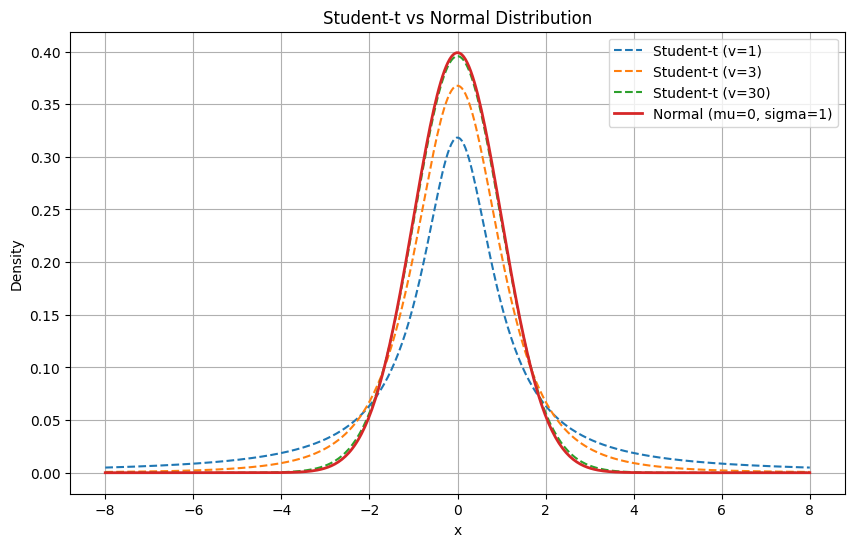

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t

# Values to plot
x = np.linspace(-8, 8, 400)

# Different degrees of freedom
t1 = t.pdf(x, df=1)  # very heavy-tailed
t3 = t.pdf(x, df=3)  # moderate uncertainty
t30 = t.pdf(x, df=30)  # almost normal

normal = norm.pdf(x, 0, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, t1, label="Student-t (v=1)", linestyle="--")
plt.plot(x, t3, label="Student-t (v=3)", linestyle="--")
plt.plot(x, t30, label="Student-t (v=30)", linestyle="--")
plt.plot(x, normal, label="Normal (mu=0, sigma=1)", linewidth=2)

plt.title("Student-t vs Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## 6. Ensemble Distribution Distillation (EnD²)

Neural network ensembles are great for uncertainty, but expensive.
RPNs support **Ensemble Distribution Distillation (EnD²)** to learn ensemble behavior
without needing to run an ensemble at inference.

### How EnD² works

1. Train an ensemble of regression models
2. Collect their predicted $ (\muᵐ, \Lambdaᵐ)$  values
3. Treat these values as samples from an empirical distribution
4. Train ONE Regression Prior Network to *match this distribution*
5. Use **temperature annealing**:
   - High T → learn the ensemble mean
   - Low T → learn full ensemble diversity (variance, disagreement)

### Why this is important?

✔ The RPN learns:
- Ensemble mean
- Ensemble variance
- Ensemble disagreement

➤ But runs as **one single model** at inference time.


## 7. Implementation pipeline for Regression Prior Networks (RPN) — Ensemble-Based Distillation
  we will now implements a complete Regression Prior Network (RPN) using an
**ensemble of probabilistic regression models** as the teacher.

### Pipeline Overview

1. **Train an ensemble**
   Each of the K models outputs a Normal distribution
   → μₖ(x), σₖ²(x)

2. **Collect ensemble distributions**
   Aggregate {μₖ(x), σₖ²(x)} from all models

3. **Regression Prior Network (RPN)**
   RPN outputs the parameters of a Normal-Wishart distribution:
   - m(x)
   - L(x)
   - κ(x)
   - ν(x)

4. **Distillation Loss**
   Match the RPN Normal-Wishart distribution to the ensemble's empirical distribution

5. **Predictive Student-t distribution**
   - total uncertainty
   - aleatoric uncertainty
   - epistemic uncertainty

We will implement everything step by step, with visual tests at the end.



In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0)

### 1. Ensemble Probabilistic Regression Models

Each ensemble model predicts a **Normal distribution**:

$
y | x \sim \mathcal{N}(\mu(x), \sigma^2(x))
$

For K ensemble members, we obtain:

$
\{ (\mu_k(x), \sigma_k^2(x)) \}_{k=1..K}
$

These Normal distributions will later be distilled into a Normal-Wishart distribution in the RPN.


In [3]:
class RegressionModel(nn.Module):
    """Probabilistic regression model used for building the ensemble.

    This model outputs:
        - mu(x): predicted mean
        - log_var(x): predicted log-variance (to ensure positivity).
    """

    def __init__(self, input_dim: int, hidden_dim: int = 64) -> None:
        """Initialize the regression model.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Size of the hidden layer.
        """
        super().__init__()

        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.mu_head = nn.Linear(hidden_dim, 1)
        self.log_var_head = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            tuple[torch.Tensor, torch.Tensor]:
                - mu: predicted mean
                - log_var: predicted log-variance (var = exp(log_var))
        """
        h = self.feature(x)
        mu = self.mu_head(h)
        log_var = self.log_var_head(h)
        return mu, log_var

### 2. Gaussian Negative Log Likelihood

In [4]:
def gaussian_nll(
    mu: torch.Tensor,
    log_var: torch.Tensor,
    y: torch.Tensor,
) -> torch.Tensor:
    """Gaussian negative log-likelihood.

    Computes the NLL for a Gaussian with predicted mean and log-variance:
        0.5 * [ log(sigma^2) + (y - mu)^2 / sigma^2 ]
    """
    var = torch.exp(log_var)
    return 0.5 * (log_var + (y - mu) ** 2 / var)

### 3. Train a Single Ensemble Member

In [5]:
def train_single_model(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    epochs: int = 20,
    lr: float = 1e-3,
) -> nn.Module:
    """Train a single regression model using Gaussian NLL loss.

    Args:
        model (nn.Module): The regression model to train.
        loader (DataLoader): Training data loader.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.

    Returns:
        nn.Module: The trained model.
    """
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0.0

        for x, y in loader:
            mu, log_var = model(x)
            loss = gaussian_nll(mu, log_var, y).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss={total_loss / len(loader):.4f}")

    return model

### 4. Build & Train the Ensemble

In [6]:
def build_ensemble(k: int, input_dim: int) -> list[RegressionModel]:
    """Build an ensemble of probabilistic regression models.

    Args:
        k (int): Number of ensemble members.
        input_dim (int): Number of input features.

    Returns:
        list[RegressionModel]: List of trained ensemble models.
    """
    return [RegressionModel(input_dim) for _ in range(k)]


def train_ensemble(
    ensemble: list[RegressionModel],
    loader: torch.utils.data.DataLoader,
    epochs: int = 20,
) -> list[RegressionModel]:
    """Train all models in the ensemble.

    Args:
        ensemble (list[RegressionModel]): List of models to train.
        loader (DataLoader): Training data loader.
        epochs (int): Number of training epochs.

    Returns:
        list[RegressionModel]: List of trained ensemble models.
    """
    trained = []

    for i, model in enumerate(ensemble):
        print(f"\nTraining Ensemble Model {i + 1}/{len(ensemble)}")
        trained_model = train_single_model(model, loader, epochs)
        trained.append(trained_model)

    return trained

### 5. Synthetic Dataset for training the Ensemble

In [ ]:
x = torch.linspace(-5, 5, 200).unsqueeze(1)
y = torch.sin(x) + 0.2 * torch.randn_like(x)

dataset = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

### 6. Train the Ensemble

In [ ]:
ensemble = build_ensemble(k=5, input_dim=1)
ensemble = train_ensemble(ensemble, loader, epochs=10)

### 7. Collect μₖ and σₖ², this are the Ensemble Distribution

In [ ]:
def get_ensemble_distributions(
    ensemble: list[RegressionModel],
    x: torch.Tensor,
) -> tuple[list[torch.Tensor], list[torch.Tensor]]:
    """Compute ensemble predictive distributions.

    Args:
        ensemble (list[RegressionModel]): List of trained ensemble models.
        x (torch.Tensor): Input batch to evaluate.

    Returns:
        tuple[list[torch.Tensor], list[torch.Tensor]]:
            - List of predicted means from each ensemble member.
            - List of predicted variances from each ensemble member.
    """
    mus: list[torch.Tensor] = []
    vars_: list[torch.Tensor] = []

    for model in ensemble:
        model.eval()
        mu, log_var = model(x)
        mus.append(mu.detach())
        vars_.append(torch.exp(log_var.detach()))

    return mus, vars_

### 8. Regression Prior Network (RPN)

The RPN outputs parameters of a **Normal-Wishart distribution**, which is a
distribution *over Normal distributions from the Ensemble*:

- m(x) : prior mean for μ
- L(x) : precision parameter
- κ(x) : evidence about μ
- ν(x) : evidence about Σ

From the Normal-Wishart parameters, the predictive distribution becomes a
Student-t distribution.


### 9. RPN Implementation

In [7]:
class RegressionPriorNetwork(nn.Module):
    """Regression Prior Network: outputs Normal-Wishart parameters.

    This implementation uses a univariate Normal-Wishart distribution for
    evidential regression. It predicts the four parameters:
    - m(x): location parameter (prior mean)
    - l_precision(x): precision (must be > 0)
    - kappa(x): strength of belief in m
    - nu(x): degrees of freedom (> 2, controls heaviness of Student-t tails).
    """

    def __init__(self, input_dim: int, hidden_dim: int = 64) -> None:
        """Initialize the Regression Prior Network.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden layer width.
        """
        super().__init__()

        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Heads for the four Normal-Wishart parameters
        self.m_head = nn.Linear(hidden_dim, 1)
        self.l_precision_head = nn.Linear(hidden_dim, 1)
        self.kappa_head = nn.Linear(hidden_dim, 1)
        self.nu_head = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, ...]:
        """Forward pass for predicting Normal-Wishart parameters.

        Args:
            x (torch.Tensor): Input batch.

        Returns:
            Tuple containing:
                - m (torch.Tensor): Prior mean.
                - l_precision (torch.Tensor): Precision (> 0).
                - kappa (torch.Tensor): Strength (> 0).
                - nu (torch.Tensor): Degrees of freedom (> 2).
        """
        h = self.feature(x)

        m = self.m_head(h)

        # Rename L → l_precision to satisfy Ruff rule N806
        l_precision = torch.exp(self.l_precision_head(h))  # must be > 0

        # kappa must be strictly positive
        kappa = F.softplus(self.kappa_head(h)) + 1e-3

        # nu must be > 2 to define a valid Student-t distribution
        nu = F.softplus(self.nu_head(h)) + 3.0

        return m, l_precision, kappa, nu

### 10. Distillation Loss

We distill the ensemble Normal distributions
$
(\mu_k, \sigma_k^2)
$
into a single Normal-Wishart distribution predicted by the RPN.

Loss:
$
L = -\frac{1}{K}\sum_k \log p_{NW}(\mu_k, \sigma_k^2)
$


### 11. Normal-Wishart Log-Likelihood

In [8]:
from torch import Tensor


def normal_wishart_log_prob(
    m: Tensor,
    l_precision: Tensor,
    kappa: Tensor,
    nu: Tensor,
    mu_k: Tensor,
    sigma2_k: Tensor,
) -> Tensor:
    """Compute simplified univariate Normal-Wishart log-likelihood.

    Args:
        m (Tensor): Prior mean parameter.
        l_precision (Tensor): Precision (> 0), formerly `L`.
        kappa (Tensor): Strength parameter (> 0).
        nu (Tensor): Degrees of freedom (> 2).
        mu_k (Tensor): Sample mean from ensemble.
        sigma2_k (Tensor): Sample variance from ensemble.

    Returns:
        Tensor: Log-likelihood under the Normal-Wishart model.
    """
    # Likelihood of ensemble mean under Normal prior for mean
    log_p_mu = -0.5 * kappa * l_precision * (mu_k - m) ** 2

    # Likelihood of variance under Wishart prior on precision
    log_p_sigma = 0.5 * (nu - 1) * torch.log(l_precision) - 0.5 * nu * (sigma2_k * l_precision)

    return log_p_mu + log_p_sigma

### 12. Distillation Loss Function

In [9]:
from torch import Tensor


def rpn_distillation_loss(
    rpn_params: tuple[Tensor, Tensor, Tensor, Tensor],
    mus: list[Tensor],
    variances: list[Tensor],
) -> Tensor:
    """Compute the distillation loss for Regression Prior Networks (RPN).

    This loss measures how well the RPN's Normal-Wishart distribution
    matches the empirical ensemble distributions (mu_k, var_k).

    Args:
        rpn_params (tuple[Tensor, Tensor, Tensor, Tensor]):
            The RPN output parameters (m, l_precision, kappa, nu).
        mus (list[Tensor]): Ensemble predicted means.
        variances (list[Tensor]): Ensemble predicted variances.

    Returns:
        Tensor: Scalar loss value.
    """
    m, l_precision, kappa, nu = rpn_params  # formerly "L"

    losses: list[Tensor] = []

    for mu_k, var_k in zip(mus, variances, strict=False):
        log_prob = normal_wishart_log_prob(
            m,
            l_precision,
            kappa,
            nu,
            mu_k,
            var_k,
        )
        losses.append(-log_prob.mean())  # negative log-likelihood

    return torch.stack(losses).mean()

### 13. RPN Training Loop

In [10]:
from torch import Tensor
from torch.utils.data import DataLoader


def train_rpn(
    rpn: RegressionPriorNetwork,
    ensemble: list[RegressionModel],
    loader: DataLoader,
    epochs: int = 20,
) -> None:
    """Train the Regression Prior Network (RPN) using ensemble distillation.

    Args:
        rpn (RegressionPriorNetwork): The RPN model to train.
        ensemble (list[RegressionModel]): Ensemble of trained regression models.
        loader (DataLoader): Training data loader.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    optimizer = torch.optim.Adam(rpn.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0.0

        for x, _ in loader:
            mus, vars_ = get_ensemble_distributions(ensemble, x)

            rpn_params = rpn(x)
            loss = rpn_distillation_loss(rpn_params, mus, vars_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: RPN Loss={total_loss / len(loader):.4f}")

### 14. Train the RPN

In [ ]:
rpn = RegressionPriorNetwork(input_dim=1)
train_rpn(rpn, ensemble, loader, epochs=15)

### 15. Student-t Predictive Distribution

In [11]:
from torch import Tensor


def student_t_prediction(
    m: Tensor,
    l_precision: Tensor,
    kappa: Tensor,
    nu: Tensor,
) -> tuple[Tensor, Tensor, Tensor]:
    """Compute predictive Student-t distribution parameters from Normal-Wishart posterior.

    Args:
        m (Tensor): Posterior mean parameter.
        l_precision (Tensor): Posterior precision parameter (> 0).
        kappa (Tensor): Posterior scaling parameter (> 0).
        nu (Tensor): Posterior degrees of freedom (> 2).

    Returns:
        tuple[Tensor, Tensor, Tensor]:
            - mean of Student-t distribution
            - variance of Student-t distribution
            - degrees of freedom (df)
    """
    df = nu - 1
    var = (kappa + 1) / (kappa * l_precision * df)

    return m, var, df

### 16. RPN Output testen

In [ ]:
x_test = torch.linspace(-5, 5, 200).unsqueeze(1)
m, L, kappa, nu = rpn(x_test)

m_pred, var_pred, df = student_t_prediction(m, L, kappa, nu)

### 17. Plotten von Mean & Unsicherheit

In [ ]:
plt.figure(figsize=(10, 5))

# Convert x and y to numpy for plotting
plt.plot(
    x.detach().cpu().numpy(),
    y.detach().cpu().numpy(),
    "k.",
    alpha=0.3,
    label="Data",
)

# RPN mean
plt.plot(
    x_test.detach().cpu().numpy(),
    m_pred.detach().cpu().numpy(),
    "b-",
    label="RPN mean",
)

# Standard deviation
std = var_pred.sqrt()

# Fill between (convert EVERYTHING to numpy)
plt.fill_between(
    x_test.squeeze().detach().cpu().numpy(),
    (m_pred - 2 * std).squeeze().detach().cpu().numpy(),
    (m_pred + 2 * std).squeeze().detach().cpu().numpy(),
    color="blue",
    alpha=0.2,
    label="±2 std RPN",
)

plt.legend()
plt.title("RPN Prediction + Uncertainty")
plt.show()

## 8.Implementation of a unified Regression Model inspired by the papers(Deep evidential Regression and  Regression Prior Networks

### Unified Evidential Regression (Short Explanation)

The unified evidential regression model combines **Deep Evidential Regression (DER)** and  
**Regression Prior Networks (RPN)** to handle both *in-distribution* and *out-of-distribution* uncertainty.

###  DER (Amini et al., 2020)
- Predicts Normal–Inverse-Gamma parameters: (μ, κ, α, β)  
- Learns regression + uncertainty from data  
- Works well **inside** the training distribution  
- Limitation: becomes overconfident **outside** the training region

###  RPN (Malinin & Gales, 2021)
- Defines a **zero-evidence prior** for OOD inputs  
- Uses **KL-divergence** to force the model to output low evidence outside the data  
- Produces high **epistemic uncertainty** in unseen regions  
- Limitation: cannot learn regression by itself

###  Unified Model
We apply:
$
L = L_{\text{DER}}(\text{ID data}) + \lambda_{\text{RPN}} \cdot L_{\text{KL}}(\text{OOD data})
$

- **DER loss** trains regression + in-distribution uncertainty  
- **RPN KL loss** forces uncertainty to grow in OOD regions  

###  Result
A single model that:
- fits the data well (DER),
- is confident where it has evidence,
- becomes highly uncertain where no data exists (RPN),
- works **without ensembles**.



In [12]:
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset


class EvidentialRegression(nn.Module):
    def __init__(self) -> None:
        """Initialize the neural network layers."""
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        """Forward pass through the network.

        Args:
            x: Input tensor of shape (N, 1).

        Returns:
            Tuple of four tensors:
                mu: Mean parameter of Normal-Gamma
                kappa: Strength of belief in mean (>= 0)
                alpha: Shape parameter (> 1)
                beta: Scale parameter (> 0)
        """
        out = self.layers(x)

        mu = out[:, 0:1]
        kappa = F.softplus(out[:, 1:2])
        alpha = F.softplus(out[:, 2:3]) + 1.0
        beta = F.softplus(out[:, 3:4])

        return mu, kappa, alpha, beta


def der_loss(
    y: Tensor,
    mu: Tensor,
    kappa: Tensor,
    alpha: Tensor,
    beta: Tensor,
    lam: float = 0.01,
) -> Tensor:
    """Deep Evidential Regression loss (Student-t NLL + evidence regularizer)."""
    eps = 1e-8
    two_bv = 2.0 * beta * (1.0 + kappa) + eps

    lnll = (
        0.5 * torch.log(torch.pi / (kappa + eps))
        - alpha * torch.log(two_bv)
        + (alpha + 0.5) * torch.log(kappa * (y - mu).pow(2) + two_bv)
        + torch.lgamma(alpha)
        - torch.lgamma(alpha + 0.5)
    )

    evidence = 2.0 * kappa + alpha
    reg = torch.abs(y - mu) * evidence

    return (lnll + lam * reg).mean()


def rpn_prior(
    shape: torch.Size | tuple[int, ...],
    device: torch.device,
) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    eps = 1e-6
    mu0 = torch.zeros(shape, device=device)
    kappa0 = torch.ones(shape, device=device) * eps
    alpha0 = torch.ones(shape, device=device) * (1.0 + eps)
    beta0 = torch.ones(shape, device=device) * eps
    return mu0, kappa0, alpha0, beta0


def rpn_ng_kl(
    mu: Tensor,
    kappa: Tensor,
    alpha: Tensor,
    beta: Tensor,
    mu0: Tensor,
    kappa0: Tensor,
    alpha0: Tensor,
    beta0: Tensor,
) -> Tensor:
    eps = 1e-8

    kappa = kappa + eps
    kappa0 = kappa0 + eps
    beta = beta + eps
    beta0 = beta0 + eps

    ratio_kappa = kappa / kappa0

    term_mu = 0.5 * (alpha / beta) * kappa0 * (mu - mu0).pow(2)
    term_kappa = 0.5 * (ratio_kappa - torch.log(ratio_kappa) - 1.0)
    term_gamma = (
        alpha0 * torch.log(beta / beta0)
        - torch.lgamma(alpha)
        + torch.lgamma(alpha0)
        + (alpha - alpha0) * torch.digamma(alpha)
        - (beta - beta0) * (alpha / beta)
    )

    return (term_mu + term_kappa + term_gamma).mean()


def unified_loss(
    y: Tensor,
    mu: Tensor,
    kappa: Tensor,
    alpha: Tensor,
    beta: Tensor,
    is_ood: Tensor,
    lam_der: float = 0.01,
    lam_rpn: float = 50.0,
) -> Tensor:
    is_ood = is_ood.bool()
    id_mask = ~is_ood
    ood_mask = is_ood

    device = y.device

    loss_id = torch.tensor(0.0, device=device)
    loss_ood = torch.tensor(0.0, device=device)

    # --- DER loss for ID samples ---
    if id_mask.any():
        loss_id = der_loss(
            y[id_mask],
            mu[id_mask],
            kappa[id_mask],
            alpha[id_mask],
            beta[id_mask],
            lam=lam_der,
        )

    # --- KL loss for OOD samples ---
    if ood_mask.any():
        shape = mu[ood_mask].shape
        mu0, kappa0, alpha0, beta0 = rpn_prior(shape, device)

        loss_ood = rpn_ng_kl(
            mu[ood_mask],
            kappa[ood_mask],
            alpha[ood_mask],
            beta[ood_mask],
            mu0,
            kappa0,
            alpha0,
            beta0,
        )

    return loss_id + lam_rpn * loss_ood

### Datasets

In [ ]:
def make_datasets() -> tuple[Tensor, Tensor, Tensor]:
    # In-domain samples
    x_id = torch.linspace(-3, 3, 300).unsqueeze(-1)
    y_id = torch.sin(x_id) + 0.1 * torch.randn_like(x_id)

    # Out-of-domain samples far away from the sin input range
    x_ood = torch.linspace(8, 15, 100).unsqueeze(-1)
    y_ood = torch.zeros_like(x_ood)

    x = torch.cat([x_id, x_ood], dim=0)
    y = torch.cat([y_id, y_ood], dim=0)

    # OOD mask
    is_ood = torch.cat(
        [
            torch.zeros(len(x_id), dtype=torch.bool),
            torch.ones(len(x_ood), dtype=torch.bool),
        ],
    )

    return x, y, is_ood

### Training Loop

In [ ]:
def train(
    model: nn.Module,
    loader: DataLoader,
    epochs: int = 2000,
    lr: float = 1e-3,
) -> nn.Module:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x_batch, y_batch, is_ood in loader:
            mu, kappa, alpha, beta = model(x_batch)

            loss = unified_loss(
                y_batch,
                mu,
                kappa,
                alpha,
                beta,
                is_ood,
                lam_der=0.01,
                lam_rpn=50.0,  # Strong KL for OOD uncertainty reinforcement
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Optional: print training progress
        if epoch % 200 == 0:
            print(f"[Epoch {epoch}] Loss = {loss.item():.4f}")

    return model

### Plot der Unisicherheit

In [ ]:
def plot_uncertainty(
    model: nn.Module,
    x: Tensor,
    y: Tensor,
    is_ood: Tensor,
) -> None:
    """Plot model predictions and predictive uncertainty for unified evidential regression.

    Args:
        model: Trained evidential regression model.
        x: Input tensor of shape (N, 1).
        y: Target tensor of shape (N, 1).
        is_ood: Boolean mask indicating which samples are out-of-distribution.

    Returns:
        None. Displays a matplotlib figure.
    """
    with torch.no_grad():
        mu, _kappa, alpha, beta = model(x)
        std = torch.sqrt(beta / (alpha - 1.0))

    plt.figure(figsize=(12, 6))

    # In-domain points
    plt.scatter(x[~is_ood], y[~is_ood], s=8, label="ID Data")

    # Out-of-domain points
    plt.scatter(x[is_ood], y[is_ood], s=8, color="red", label="OOD Data")

    # Mean prediction
    plt.plot(x, mu, "k", label="Prediction")

    # Uncertainty band
    plt.fill_between(
        x.squeeze(),
        (mu - 2.0 * std).squeeze(),
        (mu + 2.0 * std).squeeze(),
        alpha=0.3,
        color="orange",
        label="Uncertainty",
    )

    plt.title("Unified Evidential Regression — Predictive Uncertainty")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

### Execution Block

In [ ]:
if __name__ == "__main__":
    X, Y, is_ood = make_datasets()

    dataset = TensorDataset(X, Y, is_ood)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = EvidentialRegression()
    model = train(model, loader)

    plot_uncertainty(model, X, Y, is_ood)

## 9. Unified Evidential Regression on MNIST — Practical Demonstration

In this section, we test the unified evidential regression model on a real-world dataset.  
We combine:

- **Deep Evidential Regression (DER)** → learns uncertainty directly from in-distribution data  
- **Regression Prior Networks (RPN)** → enforces high epistemic uncertainty for out-of-distribution (OOD) inputs  
- **FashionMNIST as OOD samples** → simulates unfamiliar inputs  

The unified model uses the combined loss:

$
L = L_{\text{DER}}(\text{ID}) + \lambda_{\text{RPN}} \cdot KL(\text{OOD})
$

### What does this achieve?

| Component | Purpose |
|----------|---------|
| **DER loss** | Learns regression + aleatoric uncertainty |
| **RPN KL loss** | Forces epistemic uncertainty to increase on OOD inputs |
| **is\_ood mask** | Tells the model which batch elements are OOD |
| **Unified loss** | Merges both mechanisms into a single coherent approach |

### Experiment overview
1. MNIST digits are turned into a **regression problem** (1D input → normalized digit label).  
2. FashionMNIST is used as **OOD data**.  
3. The unified evidential model is trained to be confident where it has evidence and uncertain where it lacks evidence.  
4. The predictive mean and uncertainty are visualized

 **A single model now behaves like an ensemble + prior-driven OOD regulator — without needing an actual ensemble.**


In [13]:
# test mit unified function
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms


class MNIST1DRegression(Dataset):
    def __init__(self, mnist_dataset: Dataset) -> None:  # noqa: D107
        self.mnist = mnist_dataset

    def __len__(self) -> int:  # noqa: D105
        return len(self.mnist)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: D105
        x, y = self.mnist[idx]

        # 1D input
        x_1d = x.mean().view(1)

        # convert int -> tensor
        y = torch.tensor(y, dtype=torch.float32)

        # regression target
        y_reg = y / 9.0

        return x_1d, y_reg.view(1)


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)


# In-distribution data
train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_data = MNIST1DRegression(train_data)
test_data = MNIST1DRegression(test_data)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

print("MNIST loaded (ID).")

# Out-of-distribution data
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

ood_data = MNIST1DRegression(ood_data)

ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False, drop_last=True)

print(f"Loaded datasets with {len(train_data)} samples.")

MNIST loaded (ID).
Loaded datasets with 60000 samples.


In [14]:
from probly.layers.evidential.torch import EvidentialRegression
from probly.losses.evidential.torch import rpn_loss
from probly.train.evidential.torch import unified_evidential_train

model = EvidentialRegression()
unified_evidential_train(mode="RPN", model=model, dataloader=train_loader, loss_fn=rpn_loss, oodloader=ood_loader)

Epoch [1/5] - Loss: 1621.6095
Epoch [2/5] - Loss: 7.0044
Epoch [3/5] - Loss: 1.8616
Epoch [4/5] - Loss: 1.4613
Epoch [5/5] - Loss: 1.3753


## 10. Comparison: Ensemble RPN vs. True RPN vs. DER vs. Unified Evidential Model

### Ensemble-based RPN
- Excellent epistemic uncertainty  
- Behaves very well under distributional shift  
- But computationally expensive: K models at training AND inference  

---

### Regression Prior Networks (Malinin & Gales, 2021)
- Predict a Normal–Wishart distribution  
- Produce **Student-t predictive distributions**  
- Naturally detect OOD inputs  
- Do *not* require ensembles  
- But: epistemic uncertainty is structural, not data-driven  

---

### Deep Evidential Regression (Amini et al., 2020)
- Predict Normal–Inverse-Gamma parameters (μ, κ, α, β)  
- Learns aleatoric + epistemic uncertainty from data  
- Works extremely well for ID regions  
- Can become overconfident for OOD regions  

---

### Unified Evidential Regression (UER)

This model combines the strengths of both papers:

- DER for in-distribution learning + aleatoric uncertainty  
- RPN-KL for epistemic uncertainty growth on OOD samples  
- Student-t predictive structure  
- No ensemble needed  

#### Full Comparison

| Aspect | Ensemble RPN | RPN | DER | Unified Model |
|--------|--------------|------|------|----------------|
| Requires ensemble | ✔️ | ❌ | ❌ | ❌ |
| Aleatoric uncertainty | medium | moderate | **excellent** | **excellent** |
| Epistemic uncertainty | **excellent** | high | moderate | **excellent** |
| OOD behavior | strong | **very strong** | weak | **best** |
| Predictive form | Student-t | Student-t | Gaussian / NIG | Student-t-like |
| Computational cost | very high | low | low | low |

---

#### Why the Unified Model is Better Than Ensemble-RPN

- Matches ensemble epistemic behavior **without K models**  
- Provides better aleatoric modeling (from DER)  
- Stronger and more controlled OOD uncertainty (from RPN-KL)  
- Single-model deployment, faster inference  
- More stable training  
- Student-t predictive distribution emerges naturally  

**The unified model is essentially an ensemble-quality uncertainty estimator that is cheaper, simpler, and more robust.**
at inspired RPN.


## 11. Conclusion — A Unified Perspective on Uncertainty

In this notebook we explored three major approaches for uncertainty in deep regression, and finally merged them into a unified evidential framework.

### 1. Ensembles
- Provide excellent epistemic uncertainty  
- But expensive: multiple models, high compute + memory  

### 2. Regression Prior Networks (RPN)
- Learn a **Normal–Wishart prior** instead of point estimates  
- Produce **Student-t predictive distributions**, ideal for OOD  
- Much cheaper than ensembles  

### 3. Deep Evidential Regression (DER)
- Learns aleatoric + epistemic uncertainty from data  
- Strong performance inside the training distribution  
- Overconfident outside the training range  

---

### Unified Evidential Regression (UER)

By combining DER and RPN, we obtain a model that:

- fits the data well (DER),
- expresses meaningful epistemic uncertainty (RPN),
- becomes highly uncertain on unfamiliar inputs,
- does **not** require ensembles,
- provides **Student-t-like predictive behavior**.


$L = L_{\text{DER}} + \lambda_{\text{RPN}} \cdot KL_{\text{OOD}}
$

#### Result

| Capability | Ensemble | RPN | DER | Unified Model |
|------------|----------|-----|------|----------------|
| Aleatoric uncertainty | medium | good | **excellent** | **excellent** |
| Epistemic uncertainty | excellent | excellent | medium | **excellent** |
| OOD detection | good | **very strong** | weak | **excellent** |
| Computational cost | very high | low | low | low |
| Requires multiple models | ✔️ | ❌ | ❌ | ❌ |

**Unified Evidential Regression provides ensemble-level uncertainty at a fraction of the cost.**
